In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from pathlib import Path
import re
import paramiko
import contextlib
import itertools

In [28]:
LOGS = "/scratch/ag919/logs"
class ExperimentResults:
    _host_and_path = re.compile(r"^([a-zA-Z0-9.]+):(.*)$")
    def __init__(self, path, notes):
        self.host, fpath = self._host_and_path.match(path).groups()
        self.path = Path(fpath)
        self.notes = notes
    @contextlib.contextmanager
    def open(self, fname, mode="rb"):
        if self.host == os.uname().nodename:
            with open(self.path/fname, mode) as f:
                yield f
        else:
            with contextlib.closing(paramiko.SSHClient()) as ssh:
                ssh.load_system_host_keys()
                ssh.connect(self.host)
                with contextlib.closing(ssh.open_sftp()) as sftp, \
                     contextlib.closing(sftp.open(str(self.path/fname))) as f:
                        yield f
    def read_pickle(self, fname):
        with self.open(fname, "rb") as f:
            compression = ("gzip" if fname[-2:] == "gz" else None)
            return pd.read_pickle(f, compression=compression)
                     
    def __str__(self):
        return f"ExperimentResults(\"{self.host}:{self.path}\", \"\"\"{self.notes}\"\"\")"

# List of experimental results

To not get lost with the large amount of experiments in different log files, list the necessary experiments below, along with notes about them. Then, after the list, the notebook can display them in various ways. Ideally, old displaying code can be left towards the end of the notebook to allow viewing older experiments.

In [358]:
# Closed form kernels, no likelihood optimization
exp_nngp_google_v1 = ExperimentResults(f"huygens:/scratch/ag919/logs/predict/90", """
Classify CIFAR-10 using a 32-layer rectangular ReLU network, no residual layers.
This is the architecture used in the 2019 Google NNGP paper.
The kernel is calculated in closed form.

The kernel has been inverted using the minimum possible noise that doesn't give NaNs.
This version has a variance that vanishes with depth, so the results are unreliable after layer 22.
""")
exp_nngp_google_v2 = ExperimentResults("huygens:/scratch/ag919/logs/predict/92", """
Classify CIFAR-10 using a 32-layer rectangular ReLU network, no residual layers.
This is the architecture used in the 2019 Google NNGP paper.
The kernel is calculated in closed form.

The kernel has been inverted using the minimum possible noise that doesn't give NaNs.
This version has constant variance with depth (has a √2 correction factor for ReLU std).
""")

# Closed form kernel, likelihood optimization
exp_nngp_google_v3 = ExperimentResults("huygens:/scratch/ag919/logs/predict/96", """
Optimized the likelihood before doing predictions
""")

# Random feature kernels, no likelihood optimization
exp_mc_nn_double_descent = ExperimentResults("ulam:/scratch/ag919/logs/predict/5", """
Classify CIFAR-10 using a 32-layer rectangular ReLU network, no residual layers. Arch from 2019 Google NNGP paper.
Kernel calculated by drawing a bunch of random NNs, each with 16 channels.
""")

# Random feature kernels with 10k examples, likelihood optimization
exp_optl_mcnn_old = ExperimentResults("ulam:/scratch/ag919/logs/predict/46", """
Classify CIFAR-10 using a 32-layer rectangular ReLU network, no residual layers. Arch from 2019 Google NNGP paper.
Kernel calculated by drawing 138000 random NNs, each with 16 channels.

The maximum likelihood value of jitter is found, for N=50000. Smaller N use the same jitter. 
""")
 

# Plot likelihood and accuracy vs. sigma_y^2 f
exp_sigy_grid = ExperimentResults("ulam:/scratch/ag919/logs/predict_lik_vs_acc/9", """
    Plot likelihood and accuracy vs. sigma_y^2. Calculated using GPU.
    Arch from 2019 Google NNGP paper. Kernel calculated by drawing 138000 random NNs, each with 16 channels.
""")

exp_sigy_grid_k = ExperimentResults("huygens:/scratch/ag919/logs/predict_lik_vs_acc/14", """
    Plot likelihood and accuracy vs. sigma_y^2. Calculated using GPU.
    Arch from 2019 Google NNGP paper. Kernel calculated analytically.
""")

exp_sigy_grid_v2 = ExperimentResults("ulam:/scratch/ag919/logs/predict_lik_vs_acc/11", "Now with spectrum")
exp_sigy_grid_k_v2 = ExperimentResults("huygens:/scratch/ag919/logs/predict_lik_vs_acc/16", "Now with spectrum")
exp_sigy_grid_v3 = ExperimentResults("ulam:/scratch/ag919/logs/predict_lik_vs_acc/15", "Normalising the random feature kernels")

exp_sigy_grid_num_features = ExperimentResults("1", """
Like the previous experiments, but each "layer" corresponds to the a given number of features for the mean_pool
""")
exp_sigy_grid_num_features_small = ExperimentResults("ulam:/scratch/ag919/logs/predict_lik_vs_acc/30", """
Like exp_sigy_grid_num_features. Just a continuation into smaller numbers of features and training data.
""")

exp_sigy_grid_num_features_32 = ExperimentResults("huygens:/scratch/ag919/logs/predict_lik_vs_acc/24", """
Like exp_sigy_grid_num_features_small, but the NN has width 32.
""")

exp_sigy_grid_myrtle = ExperimentResults("huygens:/scratch/ag919/logs/predict_lik_vs_acc/18", """
Like the previous, but doing it for every layer of the Myrtle network,
and various numbers of training examples up to 5000.
""")

AttributeError: 'NoneType' object has no attribute 'groups'

# Plots/presentation of experimental results

In [303]:
def log_range(N):
    if N == 0:
        return []
    r = itertools.chain(
        range(500, 1000, 500),
        range(1000, 10000, 1000),
        range(10000, 50000, 5000),
        range(50000, 100000, 10000))
    return [*itertools.takewhile(lambda n: n < N, r), N]

In [17]:
with exp_nngp_google_v1.open("accuracies.pkl", "rb") as f:
    google_nngp = pd.DataFrame(pickle.load(f)).loc[:22]  # Cut layers above 22: they're buggy
with exp_nngp_google_v2.open("accuracies.pkl", "rb") as f:
    google_nngp_v2 = pd.DataFrame(pickle.load(f))
google_nngp_v2.index += 20

In [18]:
def plot_df(ax, df, things, cmap_name='viridis'):
    colors = plt.get_cmap(cmap_name)(np.linspace(0., 1., len(df)))

    for (_, row), color in zip(df.iterrows(), colors):
        ax.plot(row.index, row.values, label=f"{row.name} {things}", color=color)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel("Accuracy")

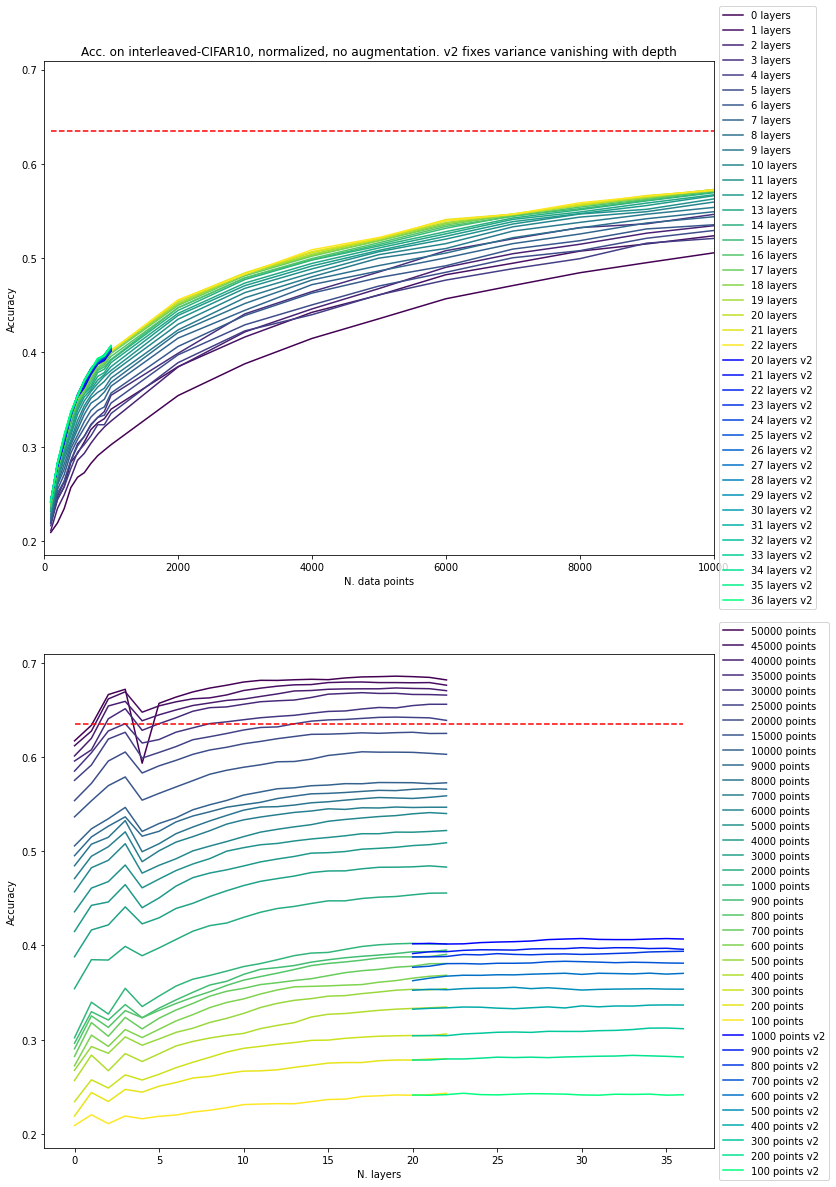

In [164]:
fig, axes = plt.subplots(2, 1, figsize=(12, 20))
axes[0].set_title("Acc. on interleaved-CIFAR10, normalized, no augmentation. v2 fixes variance vanishing with depth")
ax = axes[0]
plot_df(ax, google_nngp, "layers")
plot_df(ax, google_nngp_v2, "layers v2", 'winter')
ax.set_xlabel("N. data points")
ax.set_xlim(0, 10000)
ax = axes[1]
plot_df(ax, google_nngp.T, "points")
plot_df(ax, google_nngp_v2.T, "points v2", 'winter')
ax.set_xlabel("N. layers")

baseline_acc = .6348
layers = np.concatenate([google_nngp.index, google_nngp_v2.index])
for ax, idx in zip(axes, [google_nngp.columns, layers]):
    ax.plot([min(idx), max(idx)], [baseline_acc]*2, label="baseline", color='red', linestyle='--')

In [30]:
mc_nn_full = exp_mc_nn_double_descent.read_pickle("accuracies.pkl.gz")
mc_nn_full = mc_nn_full.dropna()

In [25]:
#mc_nn = mc_nn_full.xs(12000, level=1, axis=1)
mc_nn = mc_nn_full.stack().loc[2]

(<Figure size 864x1440 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f58217f90>,
       dtype=object))

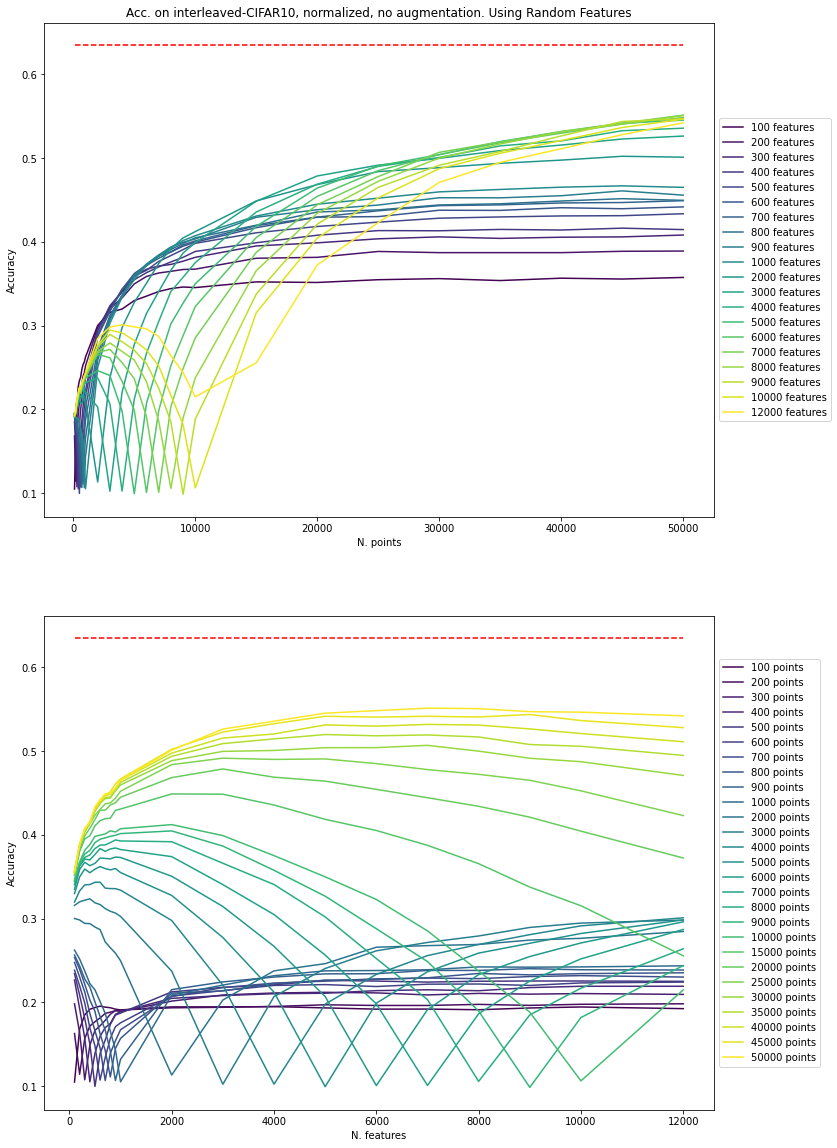

In [66]:
def full_features_plot(mc_nn, lab1="points", lab2="features"):
    fig, axes = plt.subplots(2, 1, figsize=(12, 20))
    axes[0].set_title("Acc. on interleaved-CIFAR10, normalized, no augmentation. Using Random Features")
    ax = axes[0]
    # Zoom into the beginning
    # ax.set_xlim(0, 10000)
    # ax.set_ylim(0.1, 0.4)
    plot_df(ax, mc_nn, lab2)
    ax.set_xlabel(f"N. {lab1}")
    ax = axes[1]
    plot_df(ax, mc_nn.T, lab1)
    ax.set_xlabel(f"N. {lab2}")

    baseline_acc = .6348
    layers = mc_nn.index
    for ax, idx in zip(axes, [mc_nn.columns, layers]):
        ax.plot([min(idx), max(idx)], [baseline_acc]*2, label="baseline", color='red', linestyle='--')
    return fig, axes
full_features_plot(mc_nn)

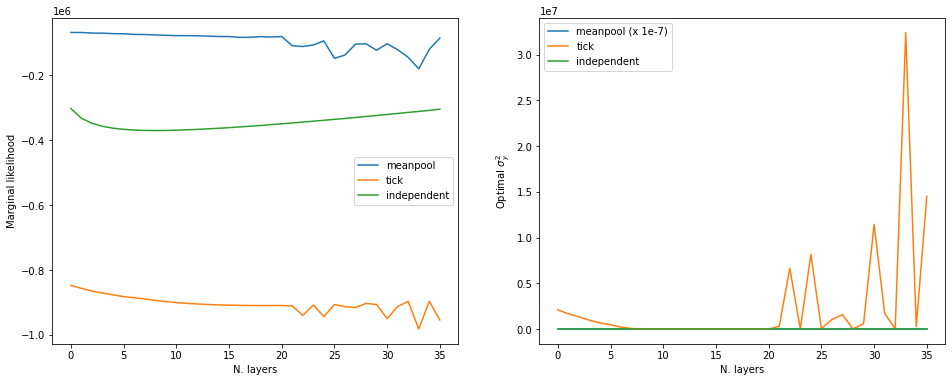

In [221]:
_, axes = plt.subplots(1, 2, figsize=(16, 6))

liks = exp_optl_mcnn.read_pickle("likelihoods.pkl")[10000]
ax = axes[0]
for i, name in enumerate(["meanpool", "tick", "independent"]):
    ax.plot(range(len(liks)//3), liks.loc[range(i, len(liks), 3)], label=name)
ax.legend()
ax.set_xlabel("N. layers")
ax.set_ylabel("Marginal likelihood")

liks = exp_optl_mcnn.read_pickle("jitters.pkl")[10000]
ax = axes[1]
for i, name in enumerate(["meanpool", "tick", "independent"]):
    factor = (1.0 if name!="meanpool" else 1e-7)
    label = (name if name!="meanpool" else "meanpool (x 1e-7)")
    ax.plot(range(len(liks)//3), liks.loc[range(i, len(liks), 3)]*factor, label=label)
ax.set_xlabel("N. layers")
ax.set_ylabel("Optimal $\sigma_y^2$")
ax.legend()

In [124]:
accuracies = exp_optl_mcnn.read_pickle("accuracies.pkl").iloc[:, :-1]
accuracies = [("independent", accuracies.loc[range(0, len(accuracies), 3)]),
              ("meanpool", accuracies.loc[range(1, len(accuracies), 3)]),
              ("tick", accuracies.loc[range(2, len(accuracies), 3)])]
for _, a in accuracies:
    a.index = range(36)

In [130]:
accuracies[0][1].iloc[-5:]

,500,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
31,0.4475,0.5121,0.579,0.6098,0.6327,0.6426,0.6585,0.6695,0.6726,0.6782,0.3526
32,0.4551,0.5166,0.5821,0.6087,0.6305,0.6437,0.6603,0.6652,0.6717,0.6754,0.2597
33,0.4605,0.5187,0.5759,0.6058,0.6275,0.6379,0.652,0.6566,0.6648,0.6635,0.1839
34,0.4379,0.5112,0.5717,0.6074,0.6268,0.6456,0.6568,0.6672,0.6739,0.6799,0.3206
35,0.4293,0.4903,0.556,0.5909,0.611,0.6259,0.6386,0.6471,0.6592,0.6529,0.3857


In [140]:
exp_optl_mcnn.read_pickle("jitters.pkl").loc[range(105-4*3, 106, 3), 10000]

93     0.821846
96       1.7104
99      4.28698
102    0.825654
105    0.191535
Name: 10000, dtype: object

Text(0.5, 1.0, 'Acc. on CIFAR10, Random Features. independent readout.')

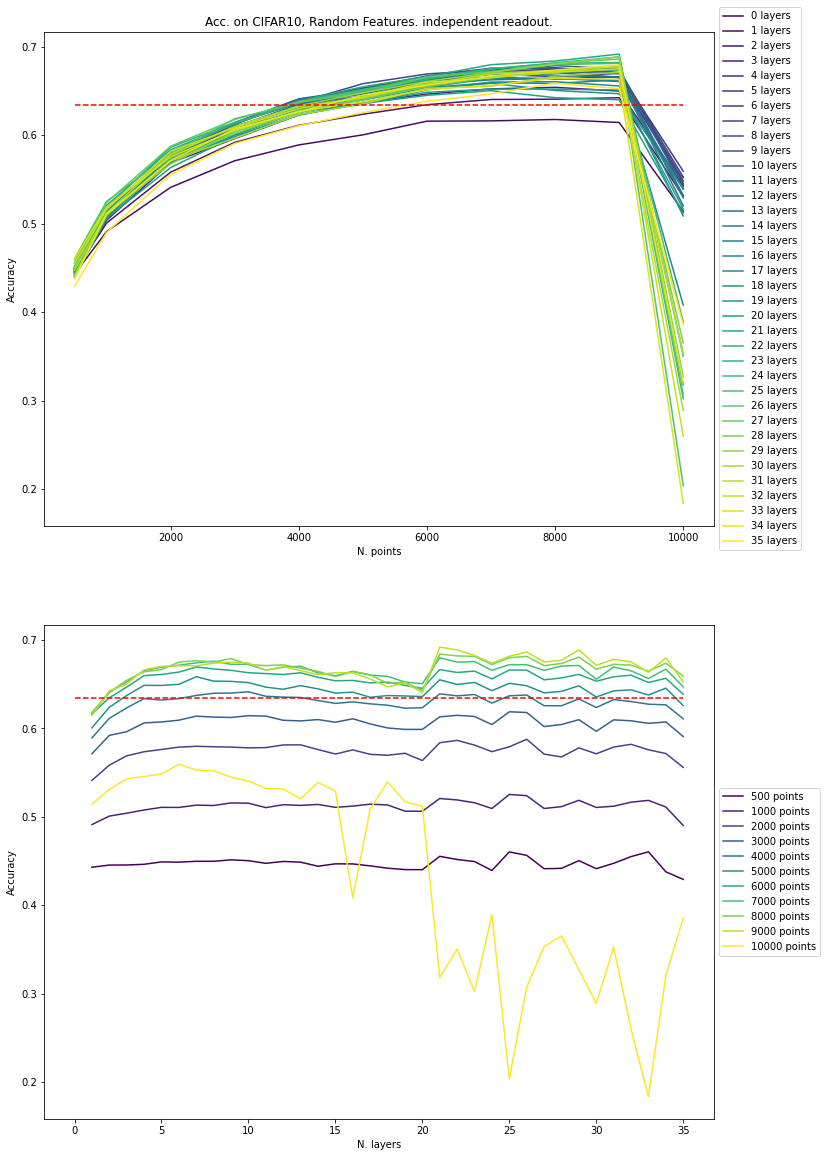

In [70]:
acc_i = 0
_, axes = full_features_plot(accuracies[acc_i][1], lab1="points", lab2="layers")
axes[0].set_title(f"Acc. on CIFAR10, Random Features. {accuracies[acc_i][0]} readout.")

Text(0.5, 1.0, 'Acc. on CIFAR10, Random Features. meanpool readout.')

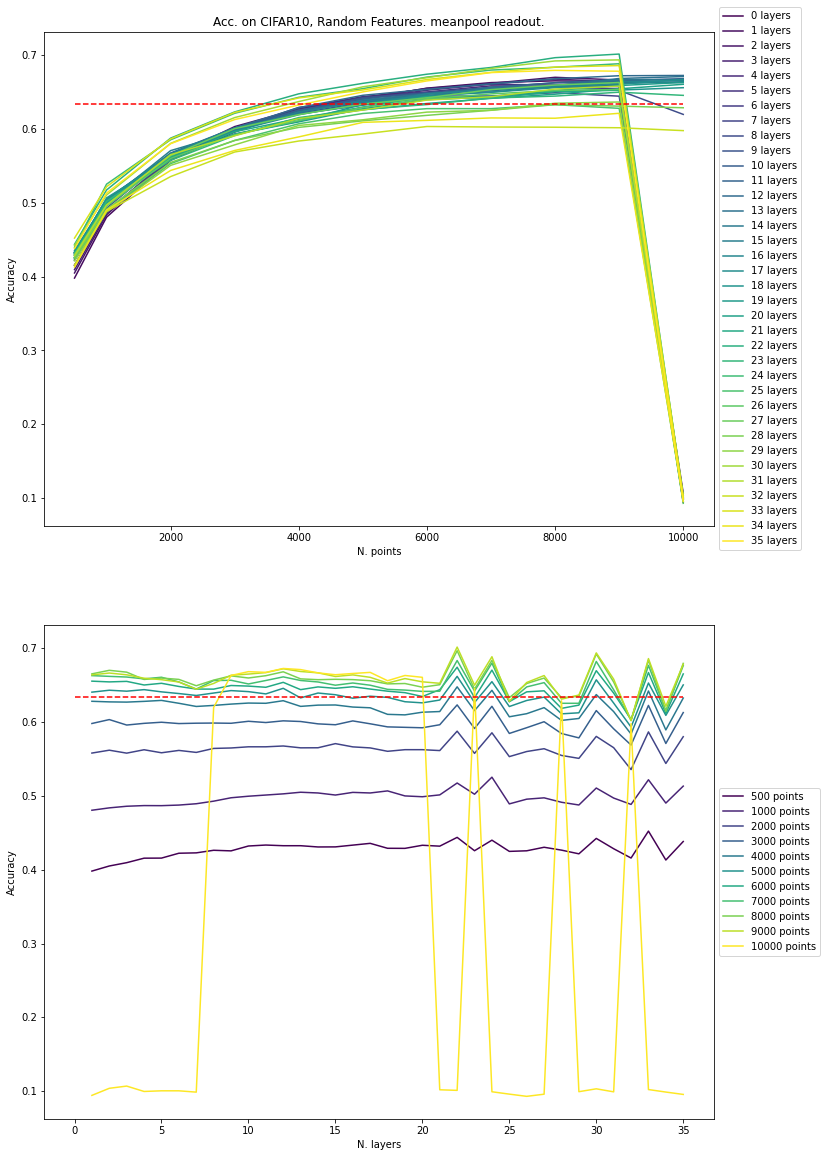

In [71]:
acc_i = 1
_, axes = full_features_plot(accuracies[acc_i][1], lab1="points", lab2="layers")
axes[0].set_title(f"Acc. on CIFAR10, Random Features. {accuracies[acc_i][0]} readout.")

Text(0.5, 1.0, 'Acc. on CIFAR10, Random Features. tick readout.')

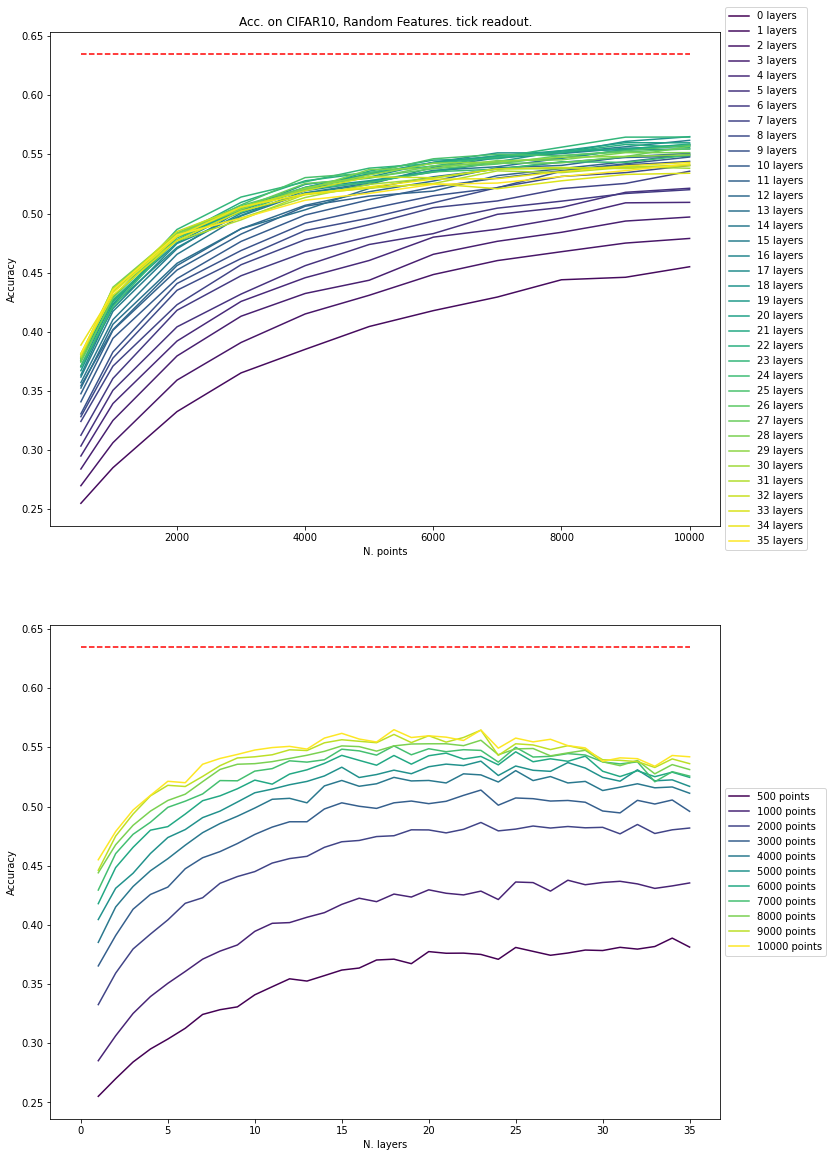

In [72]:
acc_i = 2
_, axes = full_features_plot(accuracies[acc_i][1], lab1="points", lab2="layers")
axes[0].set_title(f"Acc. on CIFAR10, Random Features. {accuracies[acc_i][0]} readout.")

In [100]:
likelihoods = exp_optl_mcnn.read_pickle("likelihoods.pkl").loc[105, 10000]
jitters = exp_optl_mcnn.read_pickle("jitters.pkl").loc[105, 10000]
accuracies[0][1].loc[35], likelihoods, jitters

(500      0.4293
 1000     0.4903
 2000      0.556
 3000     0.5909
 4000      0.611
 5000     0.6259
 6000     0.6386
 7000     0.6471
 8000     0.6592
 9000     0.6529
 10000    0.3857
 Name: 35, dtype: object, -85167.64560934348, 0.19153465203075784)

In [192]:
data = exp_sigy_grid.read_pickle("grid_lik_acc.pkl.gz")

In [193]:
def outlier_ylim(ax, v):
    vmax = v.max() + np.abs(v.max())*0.1
    vmed = np.median(v)
    ax.set_ylim(vmax - (vmax - vmed)*3, vmax)


In [271]:
data2 = exp_sigy_grid_k_v2.read_pickle("grid_lik_acc.pkl.gz")
data = exp_sigy_grid_v3.read_pickle("grid_lik_acc.pkl.gz")
data[108, 10000] = data2[35, 10000]

5.716967376663558e-06 2.319522830243569e-16
0.00012230299715258383 2.319522830243569e-16
0.0014699564234792882 2.319522830243569e-16
4.792151708549147e-05 2.319522830243569e-16


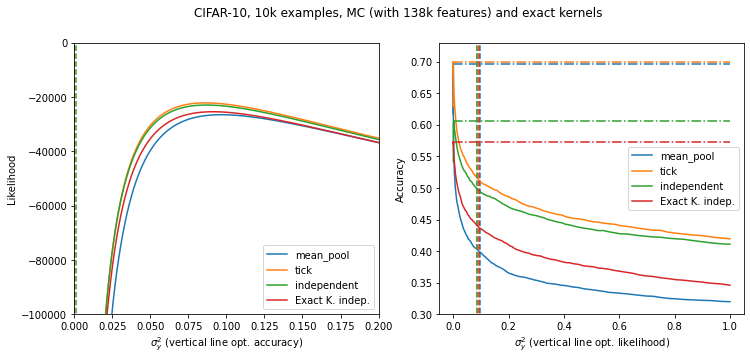

In [272]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("CIFAR-10, 10k examples, MC (with 138k features) and exact kernels")
for i, name in enumerate(["mean_pool", "tick", "independent", "Exact K. indep."]):
    idx = (i+105, 10000)
    color = f"C{i}"
    
    ax = axes[0]
    ax.plot((data[idx][0]), data[idx][1], label=name, color=color)
    ax.set_ylabel("Likelihood")
    ax.set_xlabel("$\sigma_y^2$ (vertical line opt. accuracy)")
    ax.legend()
    ax.set_ylim(-1e5, 0)
    ax.set_xlim(0, 0.2)
    
    acc_opt_i = data[idx][2].argmax()
    acc_opt_sigy = data[idx][0][acc_opt_i]
    ax.plot([acc_opt_sigy]*2, [-1e9, 1e9], color=color, linestyle='--')

    ax = axes[1]
    ax.plot((data[idx][0]), data[idx][2], label=name, color=color)
    ax.plot([data[idx][0].min(), data[idx][0].max()], [data[idx][2].max()]*2, color=color, linestyle='-.')
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("$\sigma_y^2$ (vertical line opt. likelihood)")
    ax.legend()
    ax.set_ylim(0.3, 0.73)
    
    lik_opt_i = data[idx][1].argmax()
    lik_opt_sigy = data[idx][0][lik_opt_i]
    ax.plot([lik_opt_sigy]*2, [-1e9, 1e9], color=color, linestyle='--')
    
    print(acc_opt_sigy, data[idx][0][0])

0.0004825801020447391 2.319522830243569e-16
0.00099866526144815 2.319522830243569e-16
0.0006942160929985581 2.319522830243569e-16
0.0006942160929985581 2.319522830243569e-16
0.0006942160929985581 2.319522830243569e-16
0.0006942160929985581 2.319522830243569e-16
0.0006942160929985581 2.319522830243569e-16
0.0006942160929985581 2.319522830243569e-16
0.0004825801020447391 2.319522830243569e-16
0.00033546262790251185 2.319522830243569e-16
0.0004825801020447391 2.319522830243569e-16
0.00033546262790251185 2.319522830243569e-16
0.00023319480899116346 2.319522830243569e-16
0.00011268558050780087 2.319522830243569e-16
0.00023319480899116346 2.319522830243569e-16
0.00023319480899116346 2.319522830243569e-16
0.0001621039556043436 2.319522830243569e-16
0.0001621039556043436 2.319522830243569e-16
7.833269710810084e-05 2.319522830243569e-16
3.785232391988006e-05 2.319522830243569e-16
5.445249878980472e-05 2.319522830243569e-16
3


18

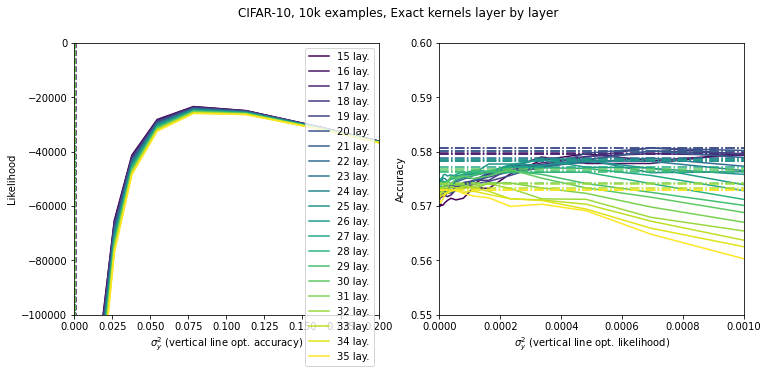

In [269]:
data = exp_sigy_grid_k.read_pickle("grid_lik_acc.pkl.gz")

layers = sorted([layer for (layer, N) in data.keys() if N==10000])
colors = plt.get_cmap(cmap_name)(np.linspace(0., 1., len(layers)))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("CIFAR-10, 10k examples, Exact kernels layer by layer")
for color, layer in zip(colors, layers):
    idx = (layer, 10000)
    name = f"{layer} lay."
    
    ax = axes[0]
    ax.plot((data[idx][0]), data[idx][1], label=name, color=color)
    ax.set_ylabel("Likelihood")
    ax.set_xlabel("$\sigma_y^2$ (vertical line opt. accuracy)")
    ax.set_ylim(-1e5, 0)
    ax.set_xlim(0, 0.2)
    
    ax.legend()
    
    acc_opt_i = data[idx][2].argmax()
    acc_opt_sigy = data[idx][0][acc_opt_i]
    ax.plot([acc_opt_sigy]*2, [-1e9, 1e9], color=color, linestyle='--')

    ax = axes[1]
    ax.plot((data[idx][0]), data[idx][2], label=name, color=color)
    ax.plot([data[idx][0].min(), data[idx][0].max()], [data[idx][2].max()]*2, color=color, linestyle='-.')
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("$\sigma_y^2$ (vertical line opt. likelihood)")
    
    #ax.set_ylim(0.3, 0.73)
    ax.set_xlim(0.0, 0.001)
    ax.set_ylim(0.55, 0.6)
    lik_opt_i = data[idx][1].argmax()
    lik_opt_sigy = data[idx][0][lik_opt_i]
    ax.plot([lik_opt_sigy]*2, [-1e9, 1e9], color=color, linestyle='--')
    print(acc_opt_sigy, data[idx][0][0])
    
print(np.argmax(list(data[layer, 10000][2].max() for layer in layers)))
layers[3]

In [279]:
feat_data = exp_sigy_grid_num_features.read_pickle("grid_lik_acc.pkl.gz")
kern_data = exp_sigy_grid_k.read_pickle("grid_lik_acc.pkl.gz")

In [336]:
sorted([k for k, _ in feat_data.keys() if k%3 == 0])

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51]

5.716967376663558e-06 2.319522830243569e-16
0.0001021376454504668 2.319522830243569e-16
0.0005709264938475773 2.1805618088629463e-15
0.0006942160929985581 2.319522830243569e-16


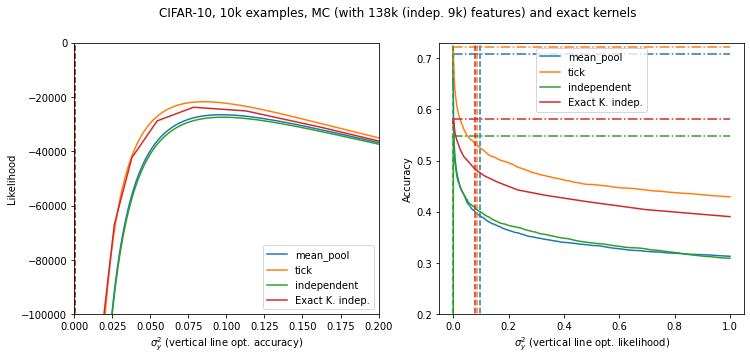

In [337]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("CIFAR-10, 10k examples, MC (with 138k (indep. 9k) features) and exact kernels")
for i, (name, grid_lik_acc) in enumerate(zip(
    ["mean_pool", "tick", "independent", "Exact K. indep."],
    [feat_data[51, 10000], feat_data[52, 10000], feat_data[8, 10000], kern_data[18, 10000]])):
    idx = (i+6, 10000)
    color = f"C{i}"
    
    ax = axes[0]
    ax.plot((grid_lik_acc[0]), grid_lik_acc[1], label=name, color=color)
    ax.set_ylabel("Likelihood")
    ax.set_xlabel("$\sigma_y^2$ (vertical line opt. accuracy)")
    ax.legend()
    ax.set_ylim(-1e5, 0)
    ax.set_xlim(0, 0.2)
    
    acc_opt_i = grid_lik_acc[2].argmax()
    acc_opt_sigy = grid_lik_acc[0][acc_opt_i]
    ax.plot([acc_opt_sigy]*2, [-1e9, 1e9], color=color, linestyle='--')

    ax = axes[1]
    ax.plot((grid_lik_acc[0]), grid_lik_acc[2], label=name, color=color)
    ax.plot([grid_lik_acc[0].min(), grid_lik_acc[0].max()], [grid_lik_acc[2].max()]*2, color=color, linestyle='-.')
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("$\sigma_y^2$ (vertical line opt. likelihood)")
    ax.legend()
    ax.set_ylim(0.2, 0.73)
    
    lik_opt_i = grid_lik_acc[1].argmax()
    lik_opt_sigy = grid_lik_acc[0][lik_opt_i]
    ax.plot([lik_opt_sigy]*2, [-1e9, 1e9], color=color, linestyle='--')
    
    print(acc_opt_sigy, grid_lik_acc[0][0])


In [355]:
data = exp_sigy_grid_myrtle.read_pickle("grid_lik_acc.pkl.gz")
different_layers, different_data = (sorted(list(set(a))) for a in zip(*data.keys()))
different_layers, different_data 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [500, 1000, 2000, 3000, 4000, 5000])

0.0002812074970026429 0.00012890885470193242
30.520123349025937 60.31623318781155
0.2523274838052461 9.18884148094706e-05
0.00023023386906178552 0.00011665161042143926
30.309931269738282 54.85950690029455
0.17088587849672948 8.370111035186043e-05
0.00023505804571357142 0.00010915335762295466
32.00195909415424 51.364305591622035
0.19602748180397433 7.756720857501861e-05
0.00027502676802849876 0.0001028631051610532
1.196135906311274 3.059441606208329
0.08906825455851962 0.00010981297454141847
0.00024220454083696824 0.00010409214785499994
1.1164440279552104 3.0735767411967907
0.09012405953189384 0.00010714808900474002
7


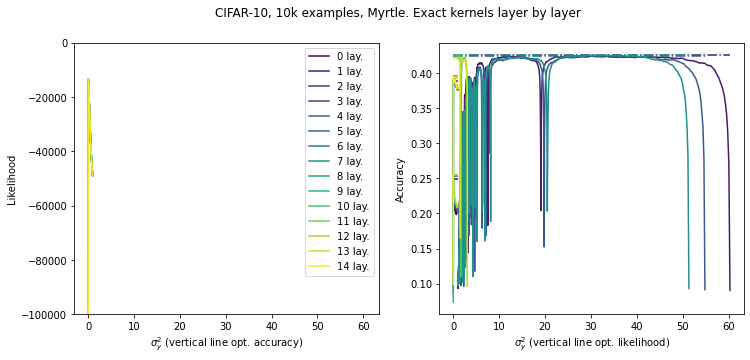

In [356]:
data = exp_sigy_grid_myrtle.read_pickle("grid_lik_acc.pkl.gz")


myrtle_df = pd.DataFrame(index=different_layers, columns=different_data)
for l in different_layers:
    for d in different_data:
        myrtle_df.loc[l, d] = data[l, d][2].max()  # max accuracy

layers = sorted([layer for (layer, N) in data.keys() if N==5000])
colors = plt.get_cmap(cmap_name)(np.linspace(0., 1., len(layers)))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("CIFAR-10, 10k examples, Myrtle. Exact kernels layer by layer")
for color, layer in zip(colors, layers):
    idx = (layer, 5000)
    name = f"{layer} lay."
    
    ax = axes[0]
    ax.plot((data[idx][0]), data[idx][1], label=name, color=color)
    ax.set_ylabel("Likelihood")
    ax.set_xlabel("$\sigma_y^2$ (vertical line opt. accuracy)")
    ax.set_ylim(-1e5, 0)
    #ax.set_xlim(0, 0.2)
    
    ax.legend()
    
    acc_opt_i = data[idx][2].argmax()
    acc_opt_sigy = data[idx][0][acc_opt_i]
    #ax.plot([acc_opt_sigy]*2, [-1e9, 1e9], color=color, linestyle='--')

    ax = axes[1]
    ax.plot((data[idx][0]), data[idx][2], label=name, color=color)
    ax.plot([0, data[idx][0].max()], [data[idx][2].max()]*2, color=color, linestyle='-.')
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("$\sigma_y^2$ (vertical line opt. likelihood)")
    
    #ax.set_xlim(0.0, 1)
    #ax.set_ylim(0.55, 0.6)
    lik_opt_i = data[idx][1].argmax()
    lik_opt_sigy = data[idx][0][lik_opt_i]
    #ax.plot([lik_opt_sigy]*2, [-1e9, 1e9], color=color, linestyle='--')
    print(acc_opt_sigy, data[idx][0][0])
    
print(np.argmax(list(data[layer, 5000][2].max() for layer in layers)))

Text(0.5, 1.0, 'Acc. on CIFAR10, 5k points, Myrtle NN.')

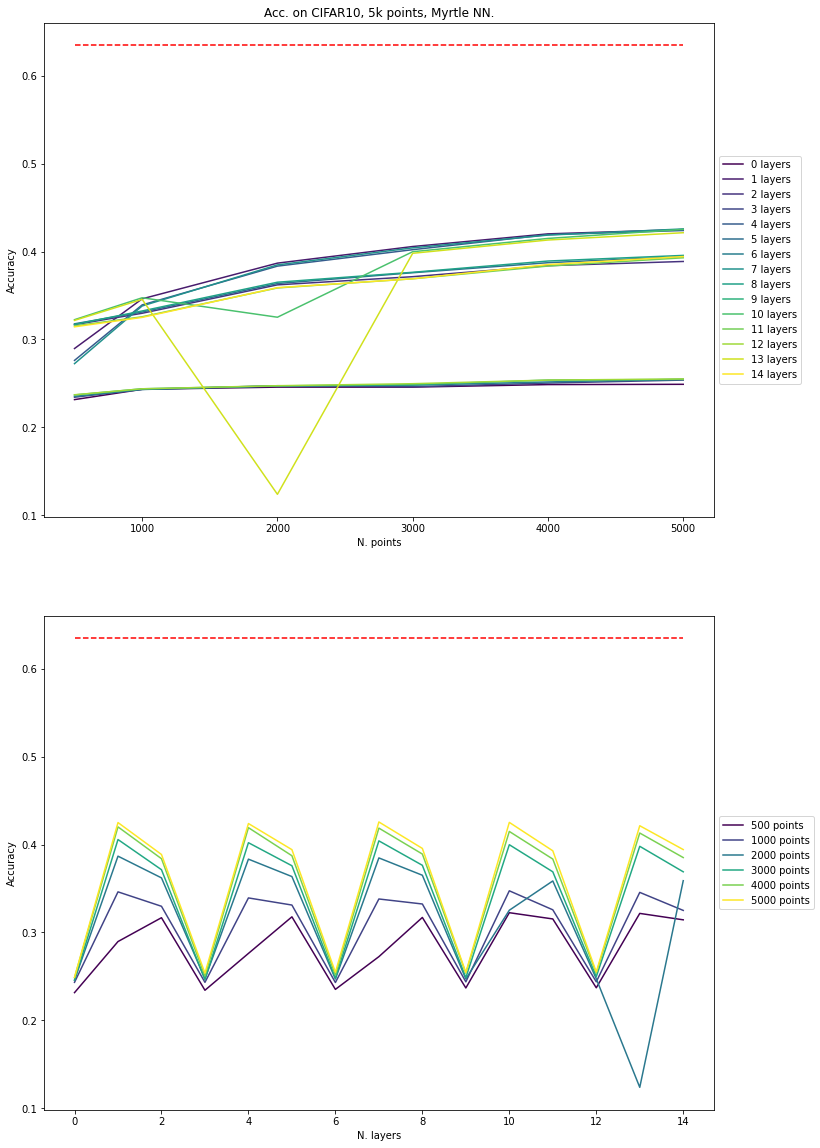

In [357]:
_, axes = full_features_plot(myrtle_df, lab1="points", lab2="layers")
axes[0].set_title(f"Acc. on CIFAR10, 5k points, Myrtle NN.")

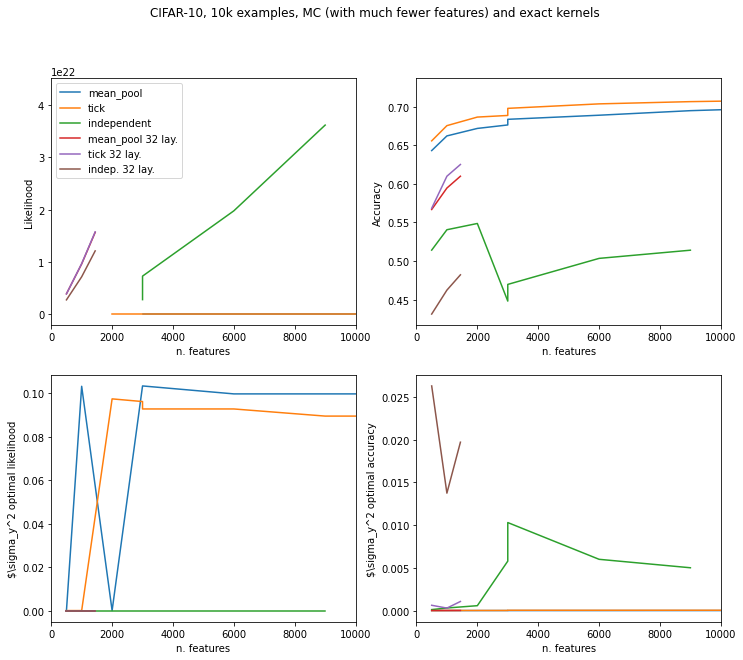

In [326]:
data = exp_sigy_grid_num_features.read_pickle("grid_lik_acc.pkl.gz")
data_small = exp_sigy_grid_num_features_small.read_pickle("grid_lik_acc.pkl.gz")

for layer, n_train, n_feat in data_small.keys():
    if n_train==10000:
        data[layer+333, n_feat] = data_small[layer, n_train, n_feat]


features_per_file = [3000, 3000, 3000, 3000, 9000, 9000, 9000, 9000, 9000,
                     9000, 9000, 9000, 9000, 9000, 9000, 9000, 9000, 9000]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("CIFAR-10, 10k examples, MC (with much fewer features) and exact kernels")
for i, name in enumerate(["mean_pool", "tick", "independent"]):
    keys = sorted([(k, n) for (k, n) in data.keys() if k%3 == i])
    
    X = np.concatenate([log_range(3000), np.cumsum([features_per_file[k//3] for k, _ in keys if k < 333])])
    lik_Y = [data[a][1].max() for a in keys]
    acc_Y = [data[a][2].max() for a in keys]
    lik_opt_Y = [data[a][0][data[a][1].argmax()] for a in keys]
    acc_opt_Y = [data[a][0][data[a][2].argmax()] for a in keys]
    
    color = f"C{i}"
    
    ax = axes[0, 0]
    ax.plot(X, lik_Y, label=name, color=color)
    ax.set_ylabel("Likelihood")
    ax.set_xlabel("n. features")
    #ax.set_ylim(-1e5, 0)
    #ax.set_xlim(0, 0.2)
    
    ax = axes[1, 0]
    ax.plot(X, lik_opt_Y, color=color)
    ax.set_ylabel("$\sigma_y^2 optimal likelihood")
    ax.set_xlabel("n. features")
    
    ax = axes[0, 1]
    ax.plot(X, acc_Y, label=name, color=color)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("n. features")
    #ax.set_ylim(0.3, 0.73)
    
    ax = axes[1, 1]
    ax.plot(X, acc_opt_Y, color=color)
    ax.set_ylabel("$\sigma_y^2 optimal accuracy")
    ax.set_xlabel("n. features")
    
    

data_32 = exp_sigy_grid_num_features_32.read_pickle("grid_lik_acc.pkl.gz")
for i, name in enumerate(["mean_pool", "tick", "indep."]):
    layer = 54+i
    X = log_range(1444)
    lik_Y, acc_Y, lik_opt_Y, acc_opt_Y = [], [], [], []
    for n_feat in X:
        a = (layer, 10000, n_feat)
        lik_Y.append(data_32[a][1].max())
        acc_Y.append(data_32[a][2].max())
        lik_opt_Y.append(data_32[a][0][data_32[a][1].argmax()])
        acc_opt_Y.append(data_32[a][0][data_32[a][2].argmax()])
    color = f"C{i+3}"
    name = f"{name} 32 lay."
    ax = axes[0, 0]
    ax.plot(X, lik_Y, label=name, color=color)
    ax.set_xlim(0, 10000)
    ax = axes[1, 0]
    ax.plot(X, lik_opt_Y, color=color)
    ax.set_xlim(0, 10000)
    ax = axes[0, 1]
    ax.plot(X, acc_Y, color=color)
    ax.set_xlim(0, 10000)
    ax = axes[1, 1]
    ax.plot(X, acc_opt_Y, color=color)
    ax.set_xlim(0, 10000)
    
axes[0, 0].legend()

In [315]:
data_32.keys()

dict_keys([(54, 5000, 500), (54, 5000, 1000), (54, 5000, 1444), (54, 10000, 500), (54, 10000, 1000), (54, 10000, 1444), (55, 5000, 500), (55, 5000, 1000), (55, 5000, 1444), (55, 10000, 500), (55, 10000, 1000), (55, 10000, 1444), (56, 5000, 500), (56, 5000, 1000), (56, 5000, 1444), (56, 10000, 500), (56, 10000, 1000), (56, 10000, 1444)])

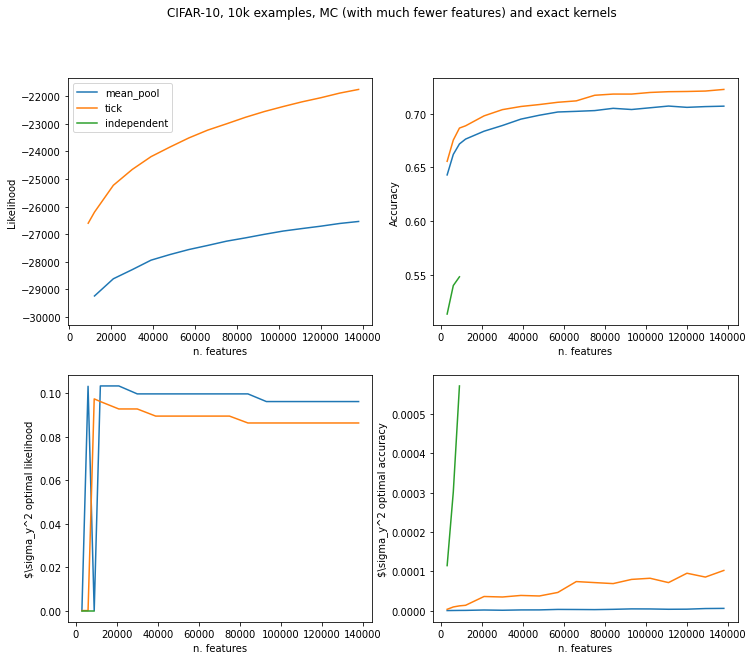

In [313]:
data = exp_sigy_grid_num_features.read_pickle("grid_lik_acc.pkl.gz")

features_per_file = [3000, 3000, 3000, 3000, 9000, 9000, 9000, 9000, 9000,
                     9000, 9000, 9000, 9000, 9000, 9000, 9000, 9000, 9000]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("CIFAR-10, 10k examples, MC (with much fewer features) and exact kernels")
for i, name in enumerate(["mean_pool", "tick", "independent"]):
    keys = sorted([(k, n) for (k, n) in data.keys() if k%3 == i])
    
    X = np.cumsum([features_per_file[k//3] for k, _ in keys])
    lik_Y = [data[a][1].max() for a in keys]
    acc_Y = [data[a][2].max() for a in keys]
    lik_opt_Y = [data[a][0][data[a][1].argmax()] for a in keys]
    acc_opt_Y = [data[a][0][data[a][2].argmax()] for a in keys]
    
    color = f"C{i}"
    
    ax = axes[0, 0]
    ax.plot(X, lik_Y, label=name, color=color)
    ax.set_ylabel("Likelihood")
    ax.set_xlabel("n. features")
    ax.legend()
    #ax.set_ylim(-1e5, 0)
    #ax.set_xlim(0, 0.2)
    
    ax = axes[1, 0]
    ax.plot(X, lik_opt_Y, color=color)
    ax.set_ylabel("$\sigma_y^2 optimal likelihood")
    ax.set_xlabel("n. features")
    
    ax = axes[0, 1]
    ax.plot(X, acc_Y, label=name, color=color)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("n. features")
    #ax.set_ylim(0.3, 0.73)
    
    ax = axes[1, 1]
    ax.plot(X, acc_opt_Y, color=color)
    ax.set_ylabel("$\sigma_y^2 optimal accuracy")
    ax.set_xlabel("n. features")

(0, 0.1)

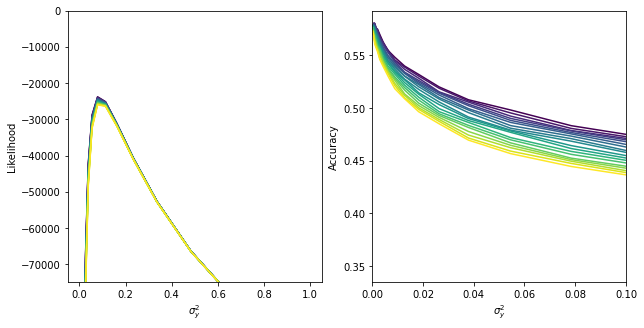

In [180]:
cmap_name = 'viridis'

data = exp_sigy_grid_k.read_pickle("grid_lik_acc.pkl.gz")
layers = sorted([layer for (layer, N) in data.keys() if N==10000])
colors = plt.get_cmap(cmap_name)(np.linspace(0., 1., len(layers)))

_, axes = plt.subplots(1, 2, figsize=(10, 5))
for c, l in zip(colors, layers):
    idx = (l, 10000)
    ax = axes[0]
    ax.plot((data[idx][0]), data[idx][1], label=idx, color=c)
    ax.set_ylabel("Likelihood")
    ax.set_xlabel("$\sigma_y^2$")

    ax = axes[1]
    ax.plot((data[idx][0]), data[idx][2], label=idx, color=c)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("$\sigma_y^2$")

    continue
    opt_i = data[idx][1].argmax()
    print("sigy, likelihood, accuracy=", data[idx][0][opt_i], data[idx][1][opt_i], data[idx][2][opt_i], opt_i)
    opt_i = data[idx][2].argmax()
    print("sigy, likelihood, accuracy=", data[idx][0][opt_i], data[idx][1][opt_i], data[idx][2][opt_i], opt_i)
axes[0].set_ylim(-7.5e4, 0)
axes[1].set_xlim(0, 0.1)

In [293]:
data.keys()

dict_keys([(52, 10000), (51, 10000), (49, 10000), (48, 10000), (46, 10000), (45, 10000), (43, 10000), (42, 10000), (40, 10000), (39, 10000), (37, 10000), (36, 10000), (34, 10000), (33, 10000), (31, 10000), (30, 10000), (28, 10000), (27, 10000), (25, 10000), (24, 10000), (22, 10000), (21, 10000), (19, 10000), (18, 10000), (16, 10000), (15, 10000), (13, 10000), (12, 10000), (10, 10000), (9, 10000), (8, 10000), (7, 10000), (6, 10000), (5, 10000), (4, 10000), (3, 10000), (2, 10000), (1, 10000), (0, 10000)])

In [296]:
exp_sigy_grid_num_features.read_pickle("grid_lik_acc.pkl.gz").keys()

dict_keys([(52, 10000), (51, 10000), (49, 10000), (48, 10000), (46, 10000), (45, 10000), (43, 10000), (42, 10000), (40, 10000), (39, 10000), (37, 10000), (36, 10000), (34, 10000), (33, 10000), (31, 10000), (30, 10000), (28, 10000), (27, 10000), (25, 10000), (24, 10000), (22, 10000), (21, 10000), (19, 10000), (18, 10000), (16, 10000), (15, 10000), (13, 10000), (12, 10000), (10, 10000), (9, 10000), (8, 10000), (7, 10000), (6, 10000), (5, 10000), (4, 10000), (3, 10000), (2, 10000), (1, 10000), (0, 10000)])

In [197]:
data_esgv2 = exp_sigy_grid_v2.read_pickle("grid_lik_acc.pkl.gz")

In [201]:
data_esgkv2 = exp_sigy_grid_k_v2.read_pickle("grid_lik_acc.pkl.gz")

/homes/ag919/venv/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


KeyError: (25, 10000)

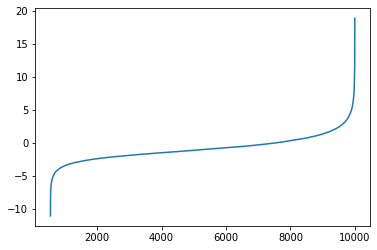

In [218]:
plt.plot(np.log(data_esgv2[105, 10000][3])
        )
plt.plot(np.log(data_esgkv2[25, 10000][3]))

In [69]:
mc_nn_50k = pd.read_pickle("../mcnn_predictions/20/accuracies.pkl.gz").dropna()

In [13]:
independent_mc_nn_50k = mc_nn_50k.loc[range(107, 70, -3), 50000].copy()
df = independent_mc_nn_50k
df.index = df.index // 3 + 1
tick_mc_nn_50k = mc_nn_50k.loc[range(106, 70, -3), 50000].copy()
df = tick_mc_nn_50k
df.index = df.index // 3 + 1

meanpool_mc_nn_50k = mc_nn_50k.loc[range(105, 70, -3), 50000].copy()
df = meanpool_mc_nn_50k
df.index = df.index // 3 + 1


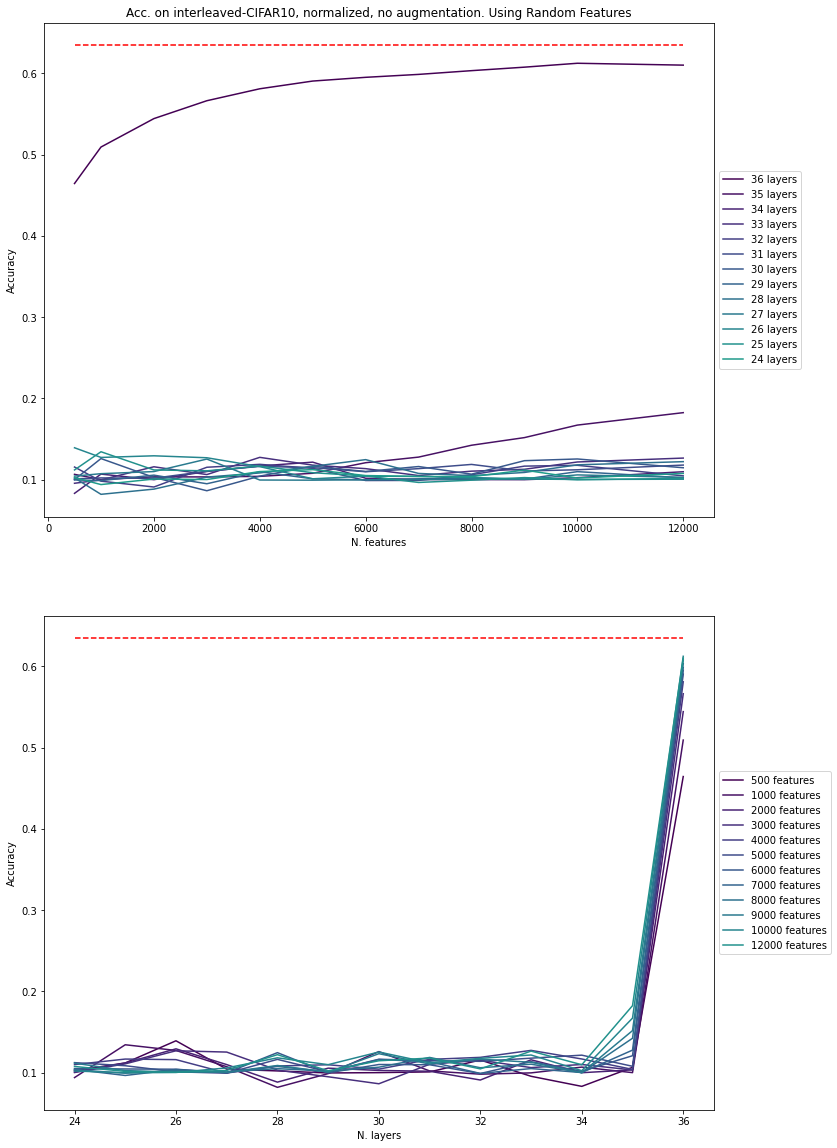

In [14]:
full_features_plot(independent_mc_nn_50k, lab1="features", lab2="layers")

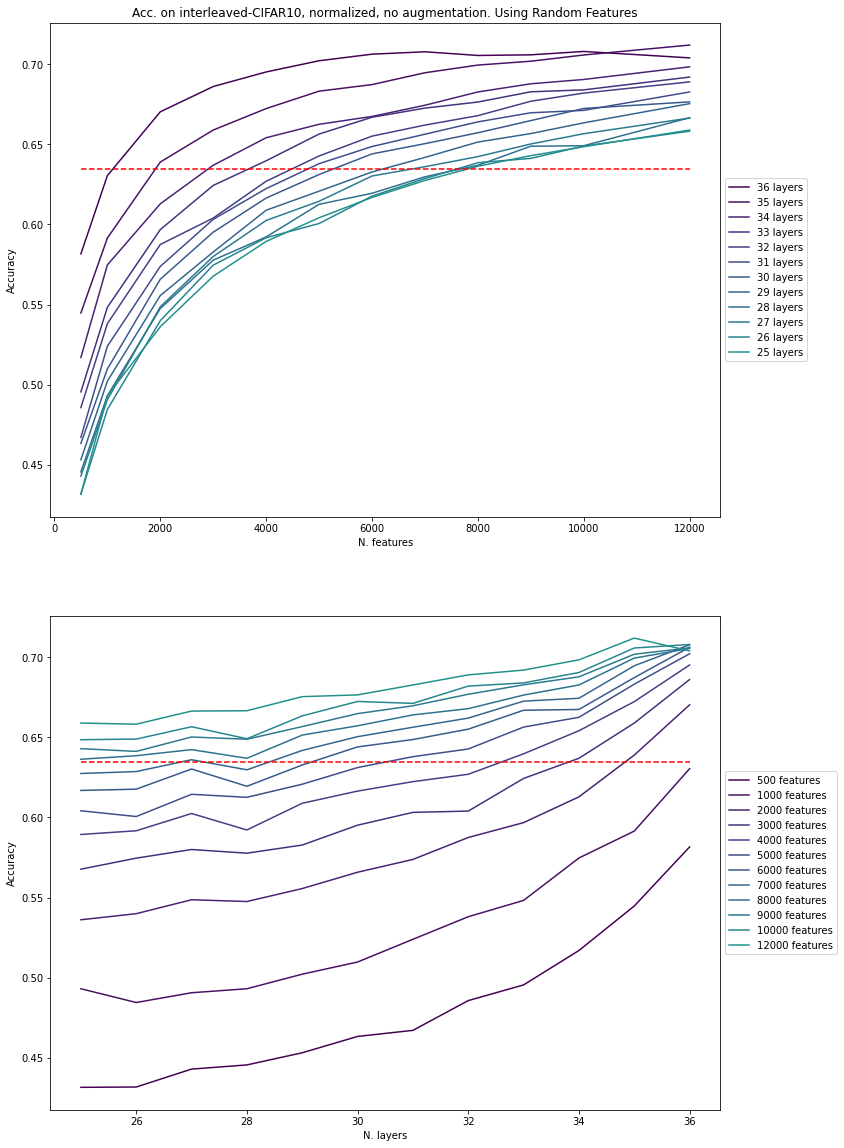

In [15]:
full_features_plot(tick_mc_nn_50k, lab1="features", lab2="layers")

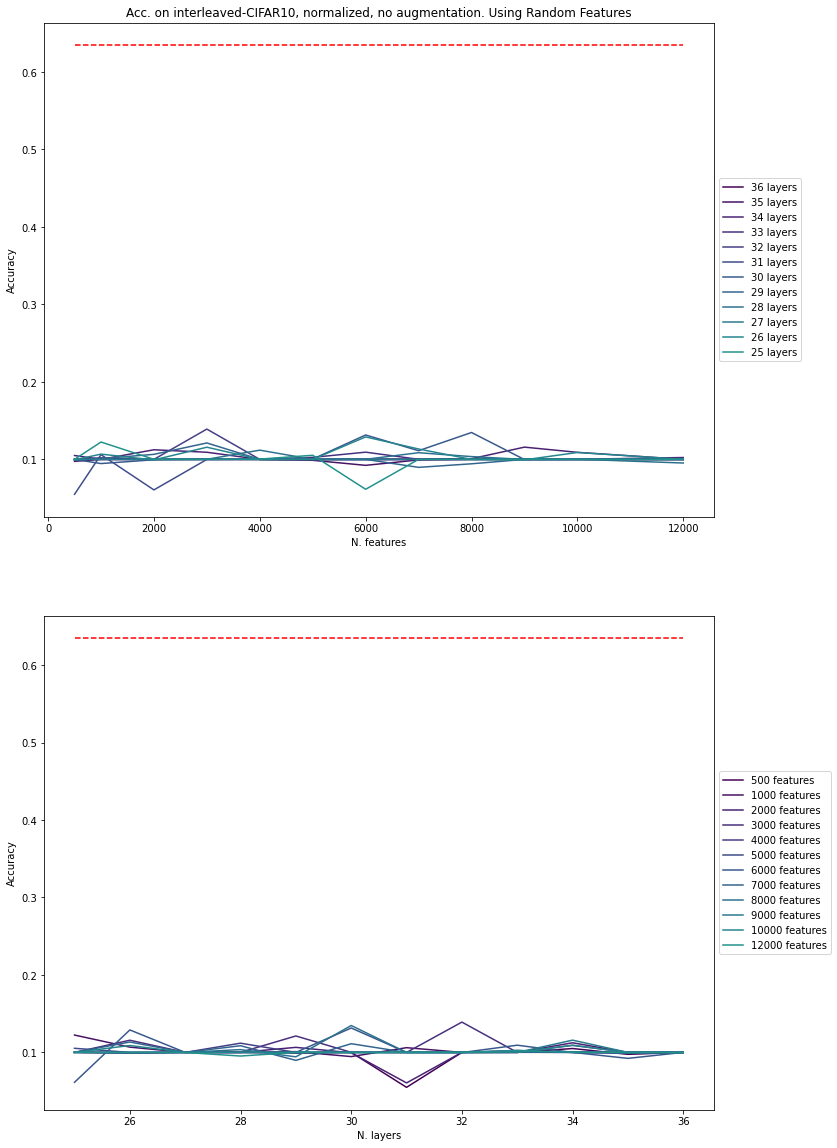

In [16]:
full_features_plot(meanpool_mc_nn_50k, lab1="features", lab2="layers")

In [17]:
mc_nn_last_layers = pd.read_pickle("../mcnn_predictions/23/accuracies.pkl.gz").dropna()

In [18]:
independent_last_layer = mc_nn_last_layers.stack().loc[107]

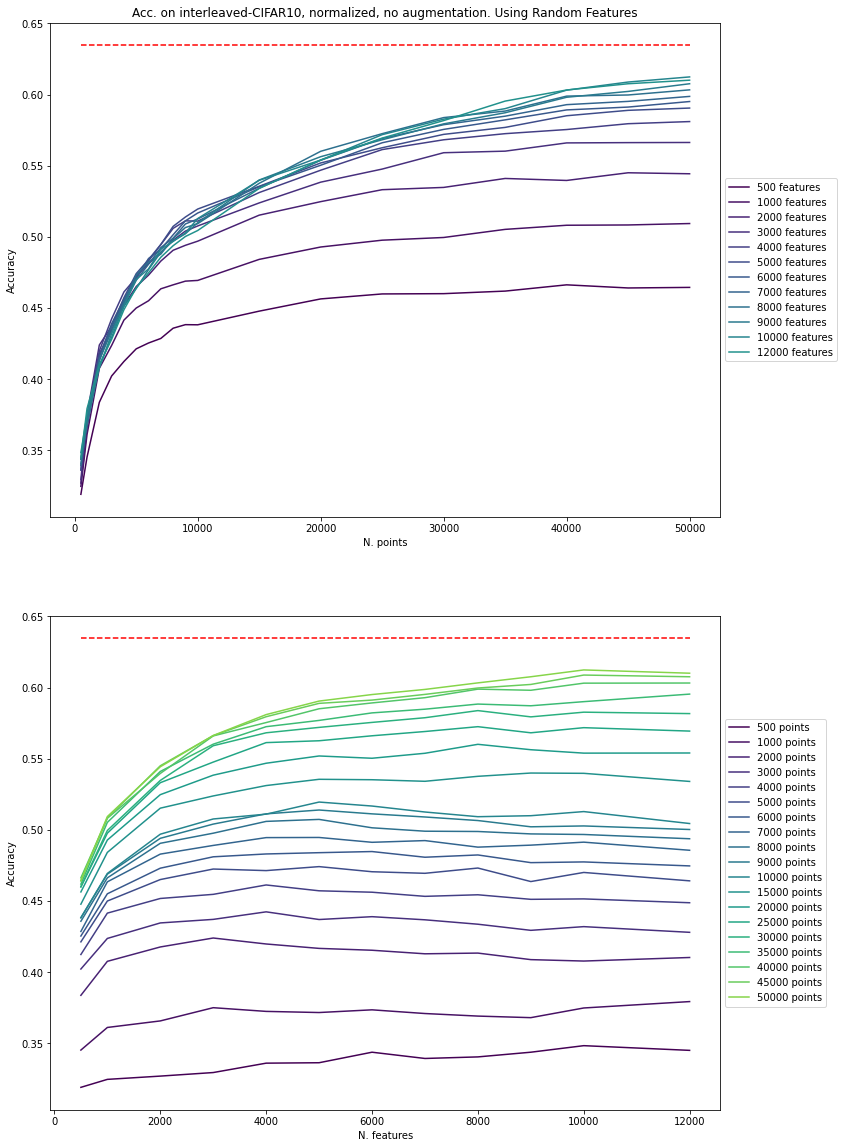

In [19]:
full_features_plot(independent_last_layer, lab1="points", lab2="features")

In [20]:
mc_nn_last_layers2 = pd.read_pickle("../mcnn_predictions/24/accuracies.pkl.gz").dropna()

In [21]:
mc_nn_last_layers2_meanpool = mc_nn_last_layers2.stack().loc[105]
mc_nn_last_layers2_tick = mc_nn_last_layers2.stack().loc[103]

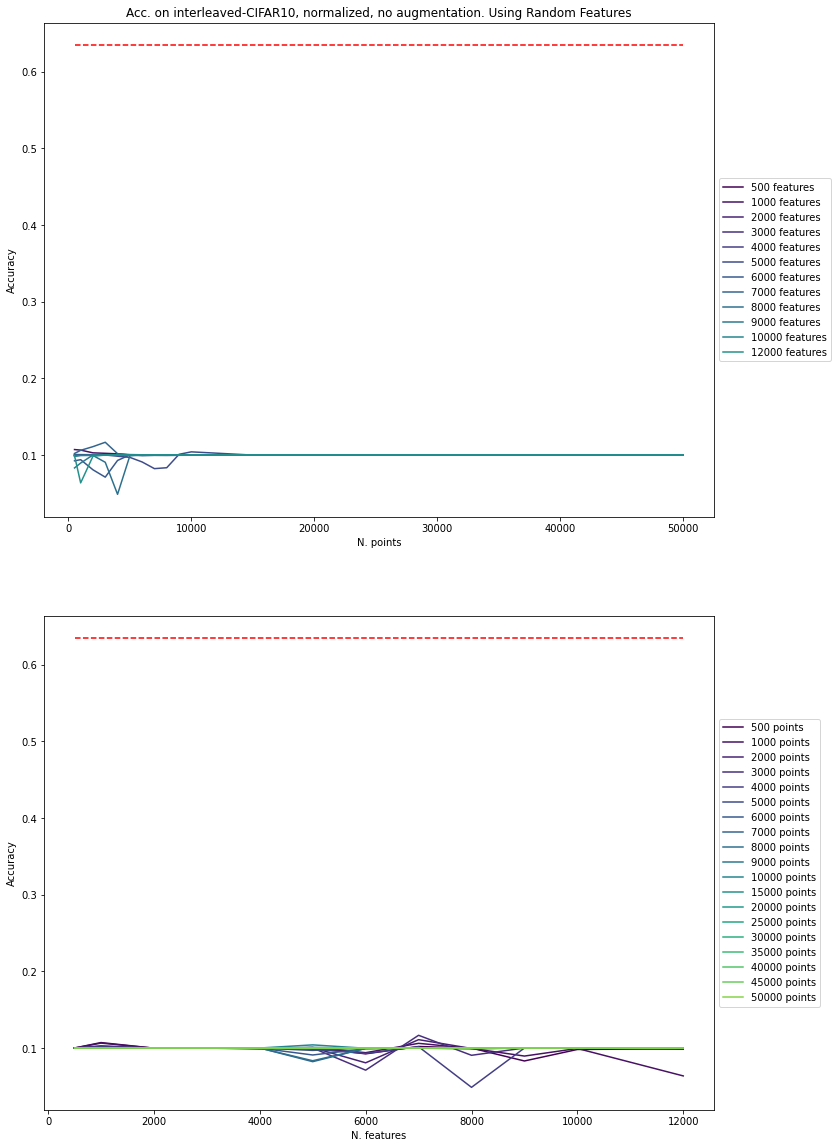

In [22]:
full_features_plot(mc_nn_last_layers2_meanpool, lab1="points", lab2="features")

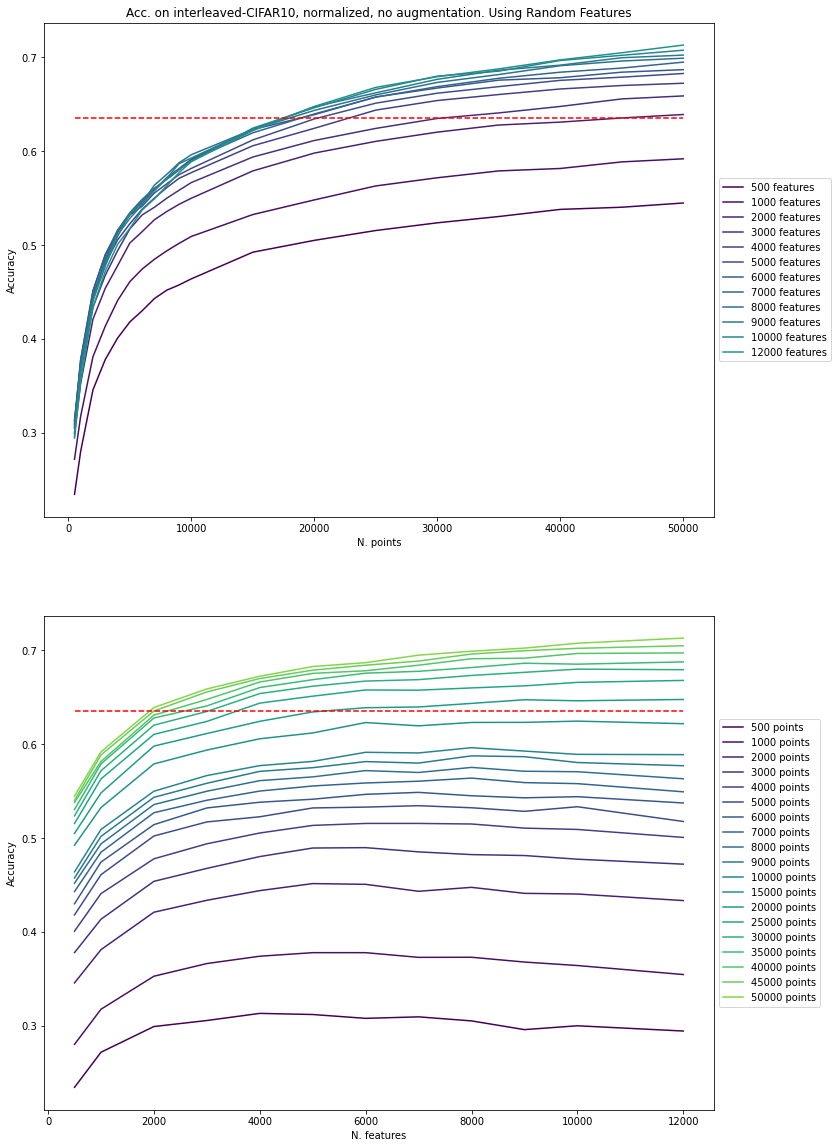

In [23]:
full_features_plot(mc_nn_last_layers2_tick, lab1="points", lab2="features")